## Binary Modeling Comparison

The purpose of this notebook is to compare the performance of random forest models on a binary output instead of the multiclass output for the Yelp NLP project.

### Import the data and the libraries

In [1]:
# Data handling and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Modeling
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
# Import the data
reviews = pd.read_csv("reviews_prep.csv")
reviews.drop('Unnamed: 0', axis = 1, inplace = True)
reviews.head(5)

,date,review,rating,title,review_prepped,title_prepped,review_tokens,review_POSes,title_tokens,title_POSes
0,2024-11-16 17:12:47,let me tell you why I named this and encouragi...,5,Encouraging App,"['let/VERB', 'me/PRON', 'tell/VERB', 'you/PRON...","['encouraging/VERB', 'app/NOUN']",let me tell you why i named this and encouragi...,VERB PRON VERB PRON SCONJ PRON VERB PRON CCONJ...,encouraging app,VERB NOUN
1,2024-11-13 19:31:04,I vaguely remember yelp being a positive exper...,1,Unreliable Dishonest Shady…. Let’s Cancel Yelp!,"['i/PRON', 'vaguely/ADV', 'remember/VERB', 'ye...","['unreliable/ADJ', 'dishonest/INTJ', 'let/VERB...",i vaguely remember yelp being a positive exper...,PRON ADV VERB NOUN AUX DET ADJ NOUN PRON AUX A...,unreliable dishonest let us cancel yelp,ADJ INTJ VERB PRON VERB NOUN
2,2024-10-11 18:43:56,I will not be using Yelp ever again. After a t...,1,Horrible,"['i/PRON', 'will/AUX', 'not/PART', 'be/AUX', '...",['horrible/ADJ'],i will not be using yelp ever again after a te...,PRON AUX PART AUX VERB NOUN ADV ADV ADP DET AD...,horrible,ADJ
3,2024-09-22 20:35:32,During think tank meetings with other business...,1,Is yelp fair?,"['during/ADP', 'think/NOUN', 'tank/NOUN', 'mee...","['is/AUX', 'yelp/NOUN', 'fair/ADJ']",during think tank meetings with other business...,ADP NOUN NOUN NOUN ADP ADJ NOUN NOUN ADP PRON ...,is yelp fair,AUX NOUN ADJ
4,2024-10-24 17:15:35,"Brought my 2023 car, with 15,454 miles, to hav...",1,"Discount Tire - Plymouth, MN","['brought/VERB', 'my/PRON', 'car/NOUN', 'with/...","['discount/NOUN', 'tire/NOUN', 'plymouth/PROPN...",brought my car with miles to have my snow tire...,VERB PRON NOUN ADP NOUN PART VERB PRON NOUN NO...,discount tire plymouth mn,NOUN NOUN PROPN NOUN


### Prepare the data

In [6]:
# 1. Put the reviews and labels together
reviews_labels = reviews.loc[:, ('review_tokens', 'rating')]

# 2. Convert the labels to positive (1) or negative (0)
def recategorize(label):
    if label == 4 or label == 5:
        return int(1)
    elif label == 1 or label == 2:
        return int(0)
    else:
        return np.nan

reviews_labels['rating'] = reviews_labels['rating'].apply(recategorize)

In [7]:
# Examine distribution of labels
reviews_labels.groupby(['rating'])['rating'].agg(['count'])

,count
rating,
0.0,1095
1.0,1578


In [13]:
# 3. Separate the positive from the negative
positive_reviews = reviews_labels[reviews_labels['rating'] == 1]
negative_reviews = reviews_labels[reviews_labels['rating'] == 0]

# 4.Sample the positive reviews to match the size of the negative reviews
positive_reviews = positive_reviews.sample(n = len(negative_reviews), random_state = 3)

# 5. Combine the data
reviews_balanced = pd.concat([positive_reviews, negative_reviews])

# 6. Sort the data according to index
reviews_balanced_sorted = reviews_balanced.sort_index()

# 7. Drop any NaNs
reviews_balanced_sorted.dropna(axis = 0, how = 'any', inplace = True)

In [14]:
reviews_balanced_sorted.shape

(2190, 2)

In [16]:
reviews_balanced_sorted.groupby(['rating'])['rating'].agg(['count'])

,count
rating,
0.0,1095
1.0,1095


### Modeling and Evaluation

In [19]:
# Set up X and y
X = reviews_balanced_sorted['review_tokens']
y = reviews_balanced_sorted['rating']

In [20]:
# Create a count vecotorized version of X
from sklearn.feature_extraction.text import CountVectorizer

cvec = CountVectorizer()
cvec.fit(X)
X_cvec = cvec.transform(X)
X_cvec_df = pd.DataFrame(X_cvec.toarray(), columns = cvec.get_feature_names_out())

# Create a tf-idf transformed version of X
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()
tfidf.fit(X)
X_tfidf = tfidf.transform(X)
X_tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns = tfidf.get_feature_names_out())

In [21]:
# Train test split for each dataset
X_cvec_train, X_cvec_test, y_cvec_train, y_cvec_test = train_test_split(X_cvec_df, y, test_size=0.2, random_state=3)
X_tfidf_train, X_tfidf_test, y_tfidf_train, y_tfidf_test = train_test_split(X_tfidf_df, y, test_size=0.2, random_state=3)

# Train the models
rf_mdl_cvec = RandomForestClassifier(random_state = 3)
rf_mdl_tfidf = RandomForestClassifier(random_state = 3)

rf_mdl_cvec.fit(X_cvec_train, y_cvec_train)
rf_mdl_tfidf.fit(X_tfidf_train, y_tfidf_train)

# Make predictions
y_pred_cvec = rf_mdl_cvec.predict(X_cvec_test)
y_pred_tfidf = rf_mdl_tfidf.predict(X_tfidf_test)

In [22]:
# Evaluation for cvec
cf_cvec = confusion_matrix(y_cvec_test, y_pred_cvec, labels = rf_mdl_cvec.classes_)
cf_tfidf = confusion_matrix(y_tfidf_test, y_pred_tfidf, labels = rf_mdl_tfidf.classes_)

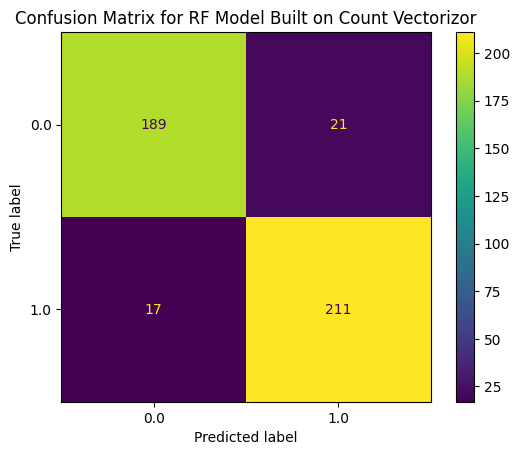

In [24]:
# Display confusion matrix 1
disp_cvec = ConfusionMatrixDisplay(confusion_matrix = cf_cvec, display_labels = rf_mdl_cvec.classes_)
disp_cvec.plot()
plt.title('Confusion Matrix for RF Model Built on Count Vectorizor')
plt.show()

In [26]:
print(classification_report(y_cvec_test, y_pred_cvec))

              precision    recall  f1-score   support

         0.0       0.92      0.90      0.91       210
         1.0       0.91      0.93      0.92       228

    accuracy                           0.91       438
   macro avg       0.91      0.91      0.91       438
weighted avg       0.91      0.91      0.91       438



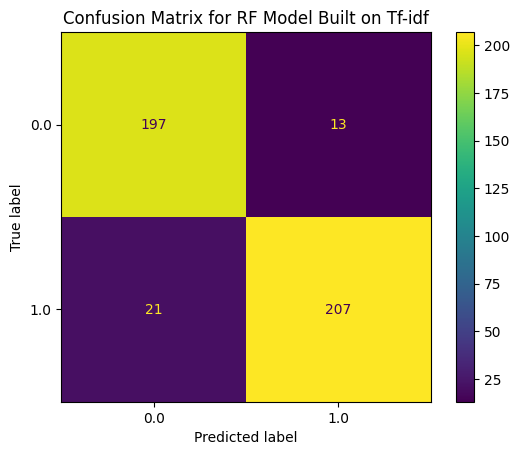

In [25]:
# Display confusion matrix 2
disp_tfidf = ConfusionMatrixDisplay(confusion_matrix = cf_tfidf, display_labels = rf_mdl_tfidf.classes_)
disp_tfidf.plot()
plt.title('Confusion Matrix for RF Model Built on Tf-idf')
plt.show()

In [27]:
print(classification_report(y_tfidf_test, y_pred_tfidf))

              precision    recall  f1-score   support

         0.0       0.90      0.94      0.92       210
         1.0       0.94      0.91      0.92       228

    accuracy                           0.92       438
   macro avg       0.92      0.92      0.92       438
weighted avg       0.92      0.92      0.92       438

